## Начало работы со скриншотами

In [22]:
from os import listdir
import cv2
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [11]:
cd Additive_Angular_Margin/

/Users/sofafeniceva/Documents/projects/project_screenshots/create_screenshot/Additive_Angular_Margin


In [14]:
path_to_images = "image/"
list_img_name = []

for img_name in listdir(path_to_images):
    if img_name.endswith('.png'):
        list_img_name.append(img_name)

In [20]:
N_img = len(list_img_name)

data_img = np.empty((N_img, 352, 152, 3))

for i, img_name in enumerate(list_img_name):
    data_img[i,:,:,:] = cv2.resize(cv2.imread(path_to_images+img_name), (152, 352))

data_img/=255

X_test = data_img[80:,:,:,:]
X_train = data_img[:80,:,:,:]

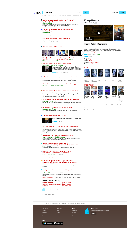

In [21]:
plt.axis("off")
plt.imshow(X_train[0])
plt.show()

In [23]:
input_img = Input(shape=(352, 152, 3))  # adapt this if using `channels_first` image data format
drop_prob_1 = 0.5

x = Conv2D(16, (7, 7), activation='relu', padding='same')(input_img)
x = Conv2D(16, (7, 7), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Flatten()(x)
x = Dense(1000, activation='relu')(x)

encoded = Dense(300, activation='relu')(x)

# x = Dense(1000, activation='relu')(encoded)
x = Dense(88*38*16, activation='relu')(encoded)

x = Reshape((88,38,16))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (7, 7), activation='relu', padding='same')(x)
decoded = Conv2D(3, (7, 7), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [28]:
checkpointer = ModelCheckpoint(filepath="weights_sign_2.hdf5", verbose=1, save_best_only=True, save_weights_only=True)

autoencoder.fit(X_train, X_train,
                epochs=2,
                batch_size=20,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer])

Train on 80 samples, validate on 20 samples
Epoch 1/2
80/80 [==============================] - 410s - loss: 0.7145 - val_loss: 0.6352
Epoch 2/2
80/80 [==============================] - 392s - loss: 0.4455 - val_loss: 0.3019


In [29]:
encoder = Model(input_img, encoded)
encoder_imgs = encoder.predict(data_img)

In [30]:
X = encoder_imgs
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(100, 2)

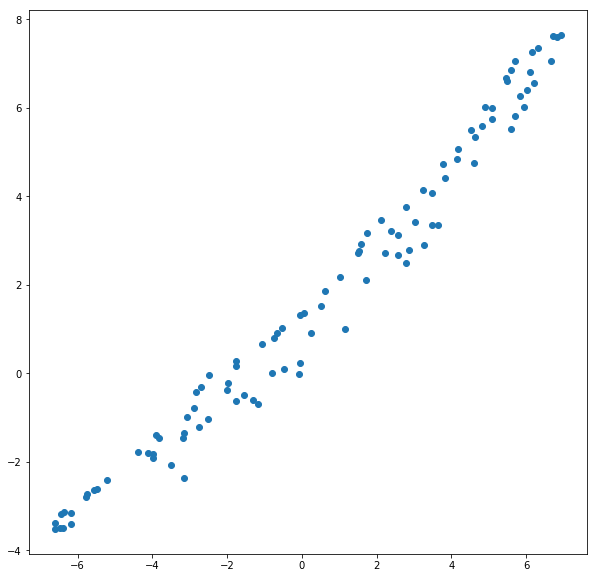

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], label='C1')
plt.show()